<a href="https://colab.research.google.com/github/jubeam/my_js_project/blob/master/class_WDF_data_0_21_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
Found 76 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 7 images belonging to 2 classes.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
1500/1500 [==============================] - 53s 35ms/step - loss: 0.3423 - acc: 0.8527 - val_loss: 0.1967 - val_acc: 0.9333
Epoch 2/100
1500/1500 [==============================] - 29s 19ms/step - loss: 0.1986 - acc: 0.9171 - val_loss: 0.

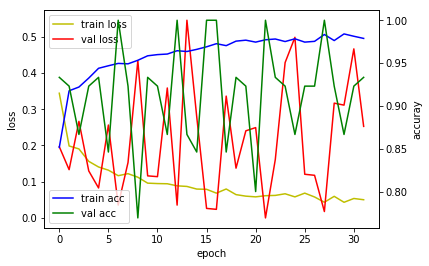

-- Evaluate --
acc: 93.33%
-- Predict --
{'cancer': 0, 'normal': 1}
[[0.000 1.000]
 [1.000 0.000]
 [0.000 1.000]
 [0.005 0.995]
 [0.988 0.012]
 [0.745 0.255]
 [0.000 1.000]
 [0.988 0.012]
 [0.000 1.000]
 [0.005 0.995]
 [0.000 1.000]
 [0.000 1.000]
 [0.745 0.255]]


In [1]:
#0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# 랜덤시드 고정시키기
np.random.seed(3)

# 1. 데이터 생성하기

from google.colab import drive
drive.mount('/gdrive', force_remount=True)
train_datagen = ImageDataGenerator(
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=15,      # 15도까지 회전
        width_shift_range=0.1,  # 10%까지 좌우 이동
        height_shift_range=0.1, # 10%까지 상하 이동
        shear_range=0.5,        # 50%까지 기울임
        zoom_range=[0.8,2.0],         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
        vertical_flip=True,
       fill_mode='nearest')
    

train_generator = train_datagen.flow_from_directory(
        '/gdrive/My Drive/Colab Notebooks/WDF/train',
        target_size=(21, 21),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/gdrive/My Drive/Colab Notebooks/WDF/test',
        target_size=(21, 21),    
        batch_size=3,
       class_mode='categorical')
real_test_datagen = ImageDataGenerator(rescale=1./255)
real_test_generator = real_test_datagen.flow_from_directory(
        '/gdrive/My Drive/Colab Notebooks/WDF/real_test',
        target_size=(21, 21),    
        batch_size=3,
       class_mode='categorical')

# 2. 모델 구성하기
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(21,21,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 10) # 조기종료 콜백함수 정의
#hist = model.fit(X_train, Y_train, epochs=3000, batch_size=10, validation_data=(X_val, Y_val), callbacks=[early_stopping])
hist= model.fit_generator(
        train_generator,
        steps_per_epoch=15 * 100,
        epochs=100,
        validation_data=test_generator,
        validation_steps=5,
        callbacks=[early_stopping]    
        )
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
# 6. 모델 평가하기
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 7. 모델 사용하기
print("-- Predict --")
output = model.predict_generator(real_test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(real_test_generator.class_indices)
print(output)